# NHL Analysis Notebook


#To Do: Logistical regression for playoffs

Here we will import data on skaters who played at least one game in the 2016-2017 NHL season. Through wrangling, cleaning, and statistical analysis/modeling, we will journey through a variety of questions including:

- Which injuries are most prevalent, and why do some go unreported?
- Where are players of different positions drafted, and how does position effect goal scoring?
- What are good predictors of salary, and can we model these relationships?
- Which performance stats predict playoff berths? 

Check out comments throughout the code to guide the analyses. 

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
%matplotlib inline

/Users/jaredgoldberg/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cd~/Documents/NHL_analysis

/Users/jaredgoldberg/Documents/NHL_analysis


In [3]:
nhl_frame = pd.read_excel("NHL 2016-17.xls", header = 2) #this data contains information on each NHL player during the 
#2016-2017 NHL season

In [4]:
nhl_frame.head() #lets check out what our data looks like

,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,...,1st,2nd,3rd,MGL,Injuries,CHIP,NMC,Status,Salary,Cap Hit
0,1988-04-30,Hamilton,ON,CAN,CAN,69,170,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UFA,575000.0,575000.0
1,1987-02-25,Muskegon,MI,USA,USA,74,218,2005.0,2.0,42.0,...,0.0,0.0,1.0,18.0,"Lower body, Knee",932926.829268,NTC,UFA,5500000.0,4250000.0
2,1993-09-23,Stockholm,NaN,SWE,SWE,71,196,2012.0,2.0,37.0,...,0.0,0.0,1.0,NaN,NaN,NaN,NaN,RFA,842500.0,780833.0
3,1991-12-01,Johnston,RI,USA,USA,70,208,NaN,NaN,NaN,...,0.0,0.0,1.0,15.0,"Lower body, Upper body",144969.512195,NaN,RFA,892500.0,792500.0
4,1992-04-30,Morristown,NJ,USA,USA,72,202,2010.0,5.0,140.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,UFA,625000.0,625000.0


In [5]:
#Now, for future reference, lets see what each of our columns are
#list(nhl_frame)

# Breaking Down Injuries

In [6]:
#First, lets find out which injuries happened the most in the NHL in 2016-2017 season
#making a list of injuries
injuries = nhl_frame["Injuries"].dropna()

In [7]:
injdict = {}
for injstr in injuries:
    for inj in injstr.lower().replace(" ", "").split(","):
        if inj in injdict.keys():
            injdict[inj] += 1
        else:
            injdict[inj] = 1
        
    
    

In [8]:
injseries = Series(injdict)

In [9]:
#injseries in case we want to see it

In [10]:
#lets combine injuries that are the same
injseries["hand"] += injseries ["thumb"] + injseries["finger"]
injseries["ankle"] += injseries["achilles"]
injseries["facial"] += injseries["eye"] + injseries["jaw"] + injseries["mouth"]
injseries["illness"] += injseries["flu"]
injseries["concussion"] += injseries["head"]
injseries["leg"] += injseries["calf"]
injseries.drop(["thumb", "finger", "achilles", "eye", "jaw", "mouth", "flu", "head", "calf"], inplace = True)

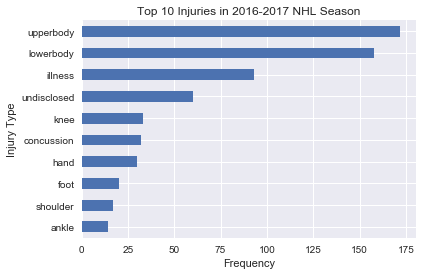

In [11]:
fig, axis = plt.subplots(1,1)
injseries.sort_values().tail(10).plot(kind = "barh", title = "Top 10 Injuries in 2016-2017 NHL Season", ax = axis)
axis.set_xlabel("Frequency")
axis.set_ylabel("Injury Type")
#We can see that many injuries are not specified, and are only reported as upper or lower body. 
#This is curious, and related to a 2008 rule about injury disclosure: 
#https://slapshot.blogs.nytimes.com/2008/11/10/the-morning-skate-nhls-new-injury-disclosure-policy-draws-heavy-criticism/
#Teams may not want to disclose injuries so opposing players cannot target

In [12]:
axis.clear()

# Organizing/Wrangling Data

In [13]:
#Lets create some useful stats for each player
now = datetime.now()
nhl_frame["Born"] = pd.to_datetime(nhl_frame["Born"])
nhl_frame["Age"] = (now - nhl_frame['Born']).astype('<m8[Y]')
nhl_frame["PPG"] = nhl_frame.PTS / nhl_frame.GP
nhl_frame.Position.unique()
positionlist = []
for each in nhl_frame.Position:
    if each == "LW":
        positionlist.append("Left Wing")
    elif each == "C":
        positionlist.append("Center")
    elif each == "D":
        positionlist.append("Defenseman")
    elif each == "RW":
        positionlist.append("Right Wing")
    elif ("LW" or "RW" or "C" in each) and ("D" in each):
        positionlist.append("Combination")
    elif ("LW" or "RW" or "C" in each) and not ("D" in each):
        positionlist.append("Combination Forward")
nhl_frame["Position_Group"] = positionlist
nhl_frame["Score_pct"] = nhl_frame.G / nhl_frame.iSF
nhl_frame["FO_PM"] = nhl_frame.iFOW - nhl_frame.iFOL
# nhl_frame["Shots"] = nhl_frame["S.Bkhd"] + nhl_frame["S.Dflct"] + nhl_frame["S.Slap"] + nhl_frame["S.Snap"] + nhl_frame["S.Tip"] + nhl_frame["S.Wrap"] + nhl_frame["S.Wrst"]
salbins = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000, 14000000]
sallabels = ["< $1 million", "$1-$2 million", "$2-$3 million", "$3-$4 million", "$4-$5 million", "$5-$6 million", "$6-$7 million", "$7-$8 million", "$8-$9 million", "$9-$10 million", "$10-$11 million", "$11-$12 million", "$12-$13 million", "$13-$14 million"]
nhl_frame["Salary_group"] = pd.cut(nhl_frame.Salary, salbins, right = False, labels = sallabels)
nhl_frame["Injuries"].replace(np.nan, "", inplace = True)
numinj = []
for each in nhl_frame.Injuries:
    if len(each) == 0:
        numinj.append(0)
    else:
        numinj.append(len(each.split(",")))
nhl_frame["num_inj"] = numinj

In [14]:
#next, lets filter this data for different analyses 
nhl_frame_23 = nhl_frame[nhl_frame.GP >= 55] #played more than 2/3 of the season
nhl_frame_5exp = nhl_frame[nhl_frame.Age >= 26] #is an experienced player, more than 5 years experience


# Analysing Players by Position
Overall breakdown, breakdown by draft round

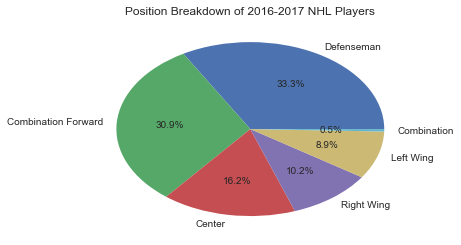

In [15]:
nhl_frame.Position_Group.value_counts().plot(kind = "pie", title = "Position Breakdown of 2016-2017 NHL Players", label = "", autopct='%1.1f%%')

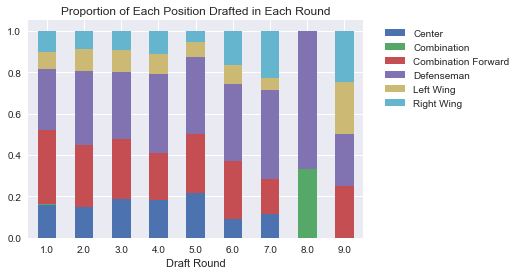

In [16]:
# nhl_frame.groupby(["DftRd", "Position_Group"]).size().unstack().plot(kind = "bar", stacked = True)
nhl_frame.groupby(["DftRd", "Position_Group"]).size().unstack().apply(lambda x: x/x.sum(), axis = 1).plot(kind = "bar", stacked = True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left") #proportion of players drafted in each round
plt.xticks(rotation = 0)
plt.title("Proportion of Each Position Drafted in Each Round")
plt.xlabel("Draft Round")
#more forwards tend to be drafted than defenseman -- which makes sense; each team starts 12 forwards, but only 6 defenseman a game

# Predicting Player Salary

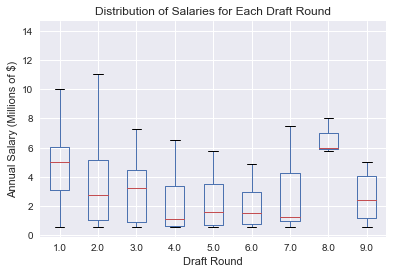

In [17]:
bp = nhl_frame_5exp.boxplot(by = "DftRd", column = "Salary") #first round drafts picks tend to be paid higher
plt.suptitle("")
bp.set_title("Distribution of Salaries for Each Draft Round")
bp.set_xlabel("Draft Round")
bp.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
bp.set_ylabel("Annual Salary (Millions of $)")


In [18]:
# #looking at salary vs. draft year
# fig, axis = plt.subplots(1,1)
# nhl_frame_5exp.plot(kind = "scatter", x="Ovrl", y = "Salary", ax = axis, title = "Salary For Experienced Players Vs. Draft Position")
# axis.set_xlabel("Draft Position")
# axis.set_ylabel("Annual Salary")


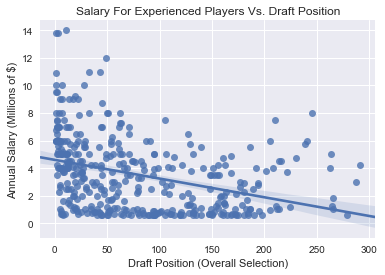

In [19]:
#lets use seaborn to visualize the relationship
sax = sns.regplot(x="Ovrl", y = "Salary", data = nhl_frame_5exp)
sax.set_title("Salary For Experienced Players Vs. Draft Position")
sax.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
sax.set_xlabel("Draft Position (Overall Selection)")
sax.set_ylabel("Annual Salary (Millions of $)")

#As we expect, later draftees tend to have lower salaries

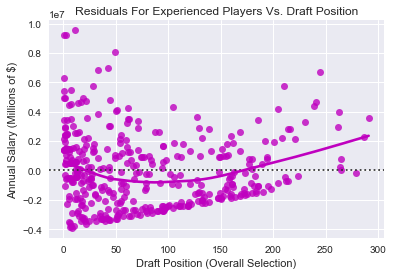

In [20]:
resid = sns.residplot(x="Ovrl", y = "Salary", data = nhl_frame_5exp, lowess = True, color = "m")
#plot to show pattern of residuals, reveals heteroscedasticity
resid.set_xlabel("Draft Position (Overall Selection)")
resid.set_ylabel("Annual Salary (Millions of $)")
resid.set_title("Residuals For Experienced Players Vs. Draft Position")

In [21]:
nhl_frame_5exp4model = nhl_frame_5exp.dropna(subset = ["Ovrl", "Salary"], how = "any")
x = nhl_frame_5exp4model.Ovrl
x = sm.add_constant(x)
y = nhl_frame_5exp4model.Salary
# x = np.vander(x,2)
salary_model = sm.OLS(y,x)
modelres = salary_model.fit()
print modelres.summary()
salslope = modelres.params["Ovrl"]
salint = modelres.params["const"]
def draft_predicted_sal(ovrl): #THIS function will predict a salary based on overall draft position, derived from our linear model
    sal = salint + salslope*ovrl
    return sal
print draft_predicted_sal(5)
# x.corr(y)
#This shows us that as you are drafted lower, your salary tends to be lower


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     56.30
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           4.26e-13
Time:                        01:29:41   Log-Likelihood:                -6327.2
No. Observations:                 392   AIC:                         1.266e+04
Df Residuals:                     390   BIC:                         1.267e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.599e+06   1.89e+05     24.362      0.0

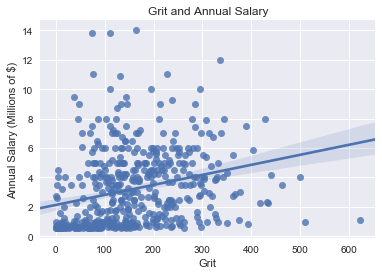

In [22]:
#Grit is an actual stat, defined as hits, blocked shots, penalty minutes, and majors
gritty_sal = sns.regplot(data = nhl_frame_5exp, x = "Grit", y = "Salary")
gritty_sal.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
gritty_sal.set_ylabel("Annual Salary (Millions of $)")
plt.title("Grit and Annual Salary")

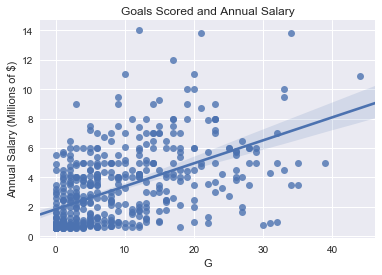

In [23]:
pct_sal = sns.regplot(data = nhl_frame_5exp, x = "G", y = "Salary")
pct_sal.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
pct_sal.set_ylabel("Annual Salary (Millions of $)")
plt.title("Goals Scored and Annual Salary")

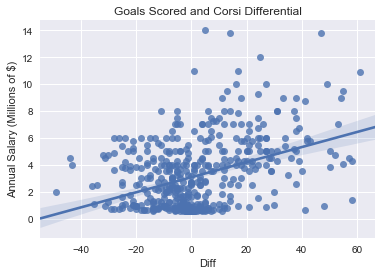

In [24]:
corsi_sal = sns.regplot(data = nhl_frame_5exp, x = "Diff", y = "Salary")
#Corsi is a common analytics hockey stat -- This includes shots on goal, missed shots on goal, and blocked shot attempts towards the opposition's net minus the same shot attempts directed at your own team's net
corsi_sal.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
corsi_sal.set_ylabel("Annual Salary (Millions of $)")
plt.title("Goals Scored and Corsi Differential")

In [25]:
#NOW, we will run a separate model with multiple performance predictors (Corsi, Goals, Grit)
#THEN, we will compare each model by plotting predicted salary with actual salary, and see which is more accurate!
nhl_frame_5exp_mul = nhl_frame_5exp.dropna(subset = ["Diff","G", "Grit", "Salary"], how = "any")
x = nhl_frame_5exp_mul[["Diff","G", "Grit"]]
x = sm.add_constant(x)
y = nhl_frame_5exp_mul.Salary
mulmodel= sm.OLS(y,x)
mul_sal = mulmodel.fit()
print mul_sal.summary()
reg_con = mul_sal.params.const
corsi_coef = mul_sal.params["Diff"]
G_sal = mul_sal.params["G"]
grit_sal = mul_sal.params["Grit"]
def performance_predicted_salary(corsi, goals, grit):
    sal = reg_con + corsi*corsi_coef + goals*G_sal + grit*grit_sal
    return sal
#It appears that Goals scored, Corsi, and Grit are all significant predictors of salary.
#As such, we have created a model that will predict salary based on these performance metrics


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     78.16
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           4.17e-41
Time:                        01:29:42   Log-Likelihood:                -7656.2
No. Observations:                 479   AIC:                         1.532e+04
Df Residuals:                     475   BIC:                         1.534e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.319e+06   1.92e+05      6.870      0.0

3155709.30633
3186321.0


/Users/jaredgoldberg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


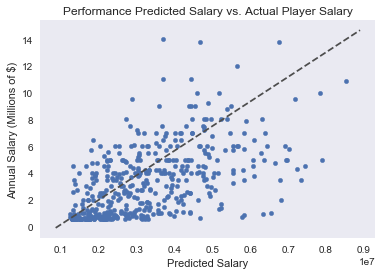

In [26]:
#How much does our model predict for someone with a average performance make? Is this near
#the actual average player salary? 
avg_goals = nhl_frame_5exp.G.mean()
avg_corsi = nhl_frame_5exp.Diff.mean()
avg_grit = nhl_frame_5exp.Grit.mean()
print performance_predicted_salary(avg_corsi,avg_goals,avg_grit)
print nhl_frame_5exp.Salary.mean()
#Our model of the average players predicts the average 5 year experience salary quite well!
#Lets compare our predicted salary with actual salary for all players
nhl_frame_5exp["pred_sal"] = nhl_frame_5exp.apply(lambda x: performance_predicted_salary(x["Diff"], x["G"], x["Grit"]), axis = 1)
pred_plot = nhl_frame_5exp.plot(kind = "scatter", y = "Salary", x = "pred_sal", grid = False)
plt.plot(pred_plot.get_xlim(), pred_plot.get_ylim(), ls="--", c=".3")
pred_plot.set_yticklabels(["", 0, 2,4,6,8,10,12,14])
pred_plot.set_ylabel("Annual Salary (Millions of $)")
pred_plot.set_xlabel("Predicted Salary")
plt.title("Performance Predicted Salary vs. Actual Player Salary")
#Not a terrible model, but not ideal

# Trends in Goal Scoring

In [27]:
#Now, we want to see how people are scoring goals in the nhl that year
#Our hypothesis is that defenseman, who play more at the point, score more of their goals via SLAPSHOT
#We also hypothesize that forward, who play closer to the net, score more of their goals with wrist or snap shots

In [28]:
nhl_frame.groupby("Position_Group").size()

Position_Group
Center                 144
Combination              4
Combination Forward    274
Defenseman             296
Left Wing               79
Right Wing              91
dtype: int64

                       G.Slap    G.Snap    G.Wrst    G.Bkhd
Position_Group                                             
Center               0.086957  0.170364  0.631766  0.110914
Combination          0.279070  0.209302  0.441860  0.069767
Combination Forward  0.094942  0.197761  0.585821  0.121476
Defenseman           0.359526  0.150700  0.446717  0.043057
Left Wing            0.072993  0.177007  0.636861  0.113139
Right Wing           0.091678  0.186178  0.612130  0.110014


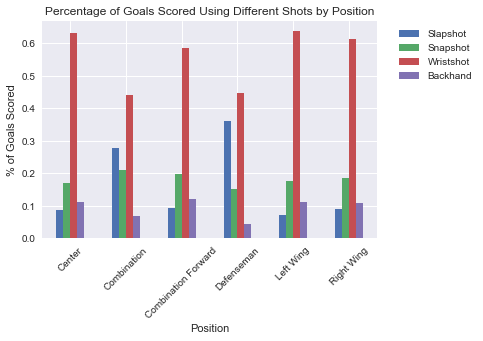

In [29]:
group_goal_pcts = nhl_frame.groupby("Position_Group")["G.Slap", "G.Snap", "G.Wrst", "G.Bkhd"].sum().apply(lambda x: x/x.sum(), axis = 1)
shots = ["Slapshot", "Snapshot", "Wristshot", "Backhand"]
print group_goal_pcts 
group_plt = group_goal_pcts.plot(kind = "bar", stacked = False)
group_plt.legend(shots, bbox_to_anchor=(1.04,1), loc="upper left")
plt.xticks(rotation = 45)
group_plt.set_xlabel("Position")
group_plt.set_ylabel("% of Goals Scored")
group_plt.set_title("Percentage of Goals Scored Using Different Shots by Position")
#We can see that Defenseman tend to score using slapshots much more often, which supports our hypothesis


In [30]:
#now lets statistically confirm the relationship between position and goal types
group_goal_tots = nhl_frame.groupby("Position_Group")["G.Slap", "G.Snap", "G.Wrst", "G.Bkhd"].sum()
chis, p_val, degof, expec = stats.chi2_contingency(group_goal_tots)
print "The p-value for our hypothesis of a relationship between position and goals scored in different ways is {}".format(p_val)
print "We reject the null hypothesis, and conclude there is a relationship between position and manner of scoring goals"
group_goal_tots

The p-value for our hypothesis of a relationship between position and goals scored in different ways is 7.94616681585e-101
We reject the null hypothesis, and conclude there is a relationship between position and manner of scoring goals


,G.Slap,G.Snap,G.Wrst,G.Bkhd
Position_Group,,,,
Center,98,192,712,125
Combination,12,9,19,3
Combination Forward,229,477,1413,293
Defenseman,334,140,415,40
Left Wing,40,97,349,62
Right Wing,65,132,434,78


                sum_sq     df         F    PR(>F)
Nat         356.679047    5.0  0.912061  0.472888
Residual  35509.094866  454.0       NaN       NaN
Our p-value is quite large, so it appears no single country on average has the most prolific goal scorers


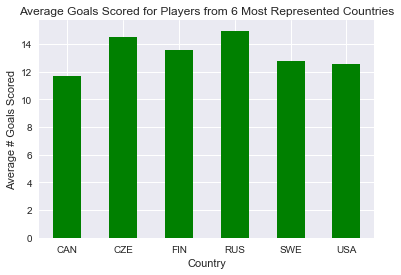

In [31]:
top_countries =  nhl_frame_23.groupby("Nat").size().sort_values(ascending = False).head(6).keys()
top_countries = [each for each in top_countries]
top_countries_frame = nhl_frame_23[nhl_frame_23["Nat"].isin(top_countries)]
cnty_plt = top_countries_frame.groupby("Nat")["G"].mean().plot(kind = "bar", title = "Average Goals Scored for Players from 6 Most Represented Countries", color = "g")
cnty_plt.set_xlabel("Country")
cnty_plt.set_ylabel("Average # Goals Scored")
plt.xticks(rotation = 0)
goal_mod = ols("G ~ Nat", data = top_countries_frame).fit()
goal_anova_output = sm.stats.anova_lm(goal_mod, typ = 2)
print goal_anova_output
print "Our p-value is quite large, so it appears no single country on average has the most prolific goal scorers"

In [32]:
#I am also curious about whether scoring efficiency (defined as goals scored per shots taken) is a predictor of total goals scored
#As in, do efficient scorers score more goals? 
nhl_frame_23["Score_pct"].corr(nhl_frame_23["G"])
#There appears to be a pretty strong correlation! Lets plot this relationship.

0.77690589073192573

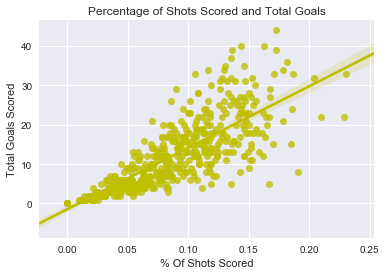

In [33]:
g_gp = sns.regplot(x="Score_pct", y = "G", data = nhl_frame_23, color = "y")
plt.title("Percentage of Shots Scored and Total Goals")
g_gp.set_xlabel("% Of Shots Scored")
g_gp.set_ylabel("Total Goals Scored")
#Quite the strong relationship

# Predicting Playoff Births

In [34]:
#Our next step is to see if playoff teams tend to have more efficient scoring
#first lets make a list of playoff teams from 2017-2017 season
traded = []
for each in nhl_frame_23.Team:
    if "/" in each:
        traded.append(False)
    else:
        traded.append(True)
nhl_frame_23_nt = nhl_frame_23[traded] #we just want players who werent traded to make it easier to organize the data
playoff_dict = {'DET': False, 'CAR': False, 'WSH' : True, 'CBJ' : True, 'CHI':True, 'WPG':False, 'NSH': True, 'BOS':True, 'CGY': True, 'VAN': False, 'NYI' : False, 'FLA': False, 'COL': False,  'MTL':True, 'PHI':False,'DAL':False, 'N.J': False, 'EDM': True, 'STL':True, 'ANA': True, 'S.J': True, 'BUF':False, 'PIT':True, 'OTT':True, 'TOR':True, 'MIN':True, 'L.A':False, 'T.B':False, 'ARI':False, 'NYR':True}
nhl_frame_23_nt["Playoff"] = nhl_frame_23_nt.Team.map(playoff_dict)


/Users/jaredgoldberg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


0.0287182806276
Our p-value < .05, so we reject null hypothesis and conclude that players on playoff teams tend to score more goals on average


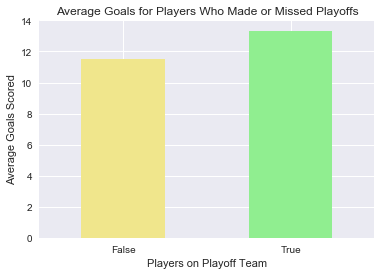

In [35]:
goal_pplot = nhl_frame_23_nt.groupby("Playoff")["G"].mean().plot(kind = "bar", color = ["khaki", "lightgreen"], title = "Average Goals for Players Who Made or Missed Playoffs")
goal_pplot.set_xlabel("Players on Playoff Team")
goal_pplot.set_ylabel("Average Goals Scored")
plt.xticks(rotation = 0)
#Lets perform an independent samples t-test at the 5% significance level to see if there is a statistical difference between goals scored
t,p,d = statsmodels.stats.weightstats.ttest_ind(nhl_frame_23_nt[nhl_frame_23_nt.Playoff == True]["G"],nhl_frame_23_nt[nhl_frame_23_nt.Playoff == False]["G"], usevar = "unequal")
print p
print "Our p-value < .05, so we reject null hypothesis and conclude that players on playoff teams tend to score more goals on average"

nan


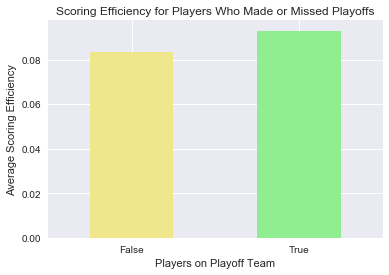

In [36]:
#Lets see if this same patters holds true for scoring efficiency
e_pplot = nhl_frame_23_nt.groupby("Playoff")["Score_pct"].mean().plot(kind = "bar", color = ["khaki", "lightgreen"], title = "Scoring Efficiency for Players Who Made or Missed Playoffs")
e_pplot.set_xlabel("Players on Playoff Team")
e_pplot.set_ylabel("Average Scoring Efficiency")
plt.xticks(rotation = 0)
#Lets perform an independent samples t-test at the 5% significance level to see if there is a statistical difference between goals scored
t,p,d = statsmodels.stats.weightstats.ttest_ind(nhl_frame_23_nt[nhl_frame_23_nt.Playoff == True]["Score_pct"],nhl_frame_23_nt[nhl_frame_23_nt.Playoff == False]["Score_pct"], usevar = "unequal")
print p

/Users/jaredgoldberg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


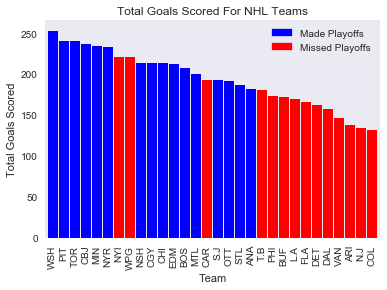

In [37]:
#Now, lets explore team by team predictors of playoff success
#well start with total goals scored
sortseries = nhl_frame_23_nt.groupby("Team")["G"].sum().sort_values(ascending = False)
sorted_teams = dict(sortseries.rank(ascending = False))
sorted_teams
nhl_frame_23_nt["Goal_rank"] = nhl_frame_23_nt["Team"].map(sorted_teams)
nhl_frame_23_nt_sort = nhl_frame_23_nt.sort_values("Goal_rank")
goal_teams = nhl_frame_23_nt_sort.groupby("Team")["G"].sum().sort_values(ascending = False)
playoffs = [playoff_dict[each] for each in goal_teams.keys()]
goal_teams = goal_teams.to_frame()
goal_teams["Playoffs"] = playoffs
bar_colors = []
for each in playoffs:
    if each == True:
        bar_colors.append("b")
    else:
        bar_colors.append("r")
goal_teams = goal_teams.reset_index()
g_plt = goal_teams.plot(kind = "bar", x = "Team", y = "G", color = bar_colors, width = .9, grid = False)
#p_gol_plt = sns.barplot(data=nhl_frame_23_nt_sort, x = "Team", y = "G", estimator = sum, hue ="Playoff", ci = None)
plt.title("Total Goals Scored For NHL Teams")
plt.xticks(rotation = 90)
plt.ylabel("Total Goals Scored")
r_patch = mpatches.Patch(color='r', label='Missed Playoffs')
b_patch = mpatches.Patch(color = "b", label = "Made Playoffs")
plt.legend(handles=[b_patch, r_patch])
#It is pretty clear that teams that score more goals tend to make the playoffs

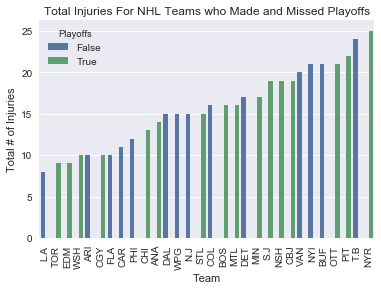

In [38]:
#you can always create a few dataframes and then merge them! 
#predictors of playoff success: goal differential, shot accuracy, goals, number of injuries, grit
inj_by_team = nhl_frame_23_nt.groupby("Team")["num_inj"].sum()
inj_by_team = inj_by_team.reset_index()
inj_by_team["Playoffs"] = inj_by_team["Team"].map(playoff_dict)
sns.barplot(data = inj_by_team.sort_values("num_inj"), x = "Team", y = "num_inj", hue = "Playoffs")
plt.title("Total Injuries For NHL Teams who Made and Missed Playoffs")
plt.xticks(rotation = 90)
plt.ylabel("Total # of Injuries")
#it is not as clear if injuries affect playoff birth

In [39]:
poff_logit_frame = nhl_frame_23_nt.groupby("Team")["G"].sum().to_frame().reset_index()
scoringp = nhl_frame_23_nt.groupby("Team")["Score_pct"].mean().to_frame().reset_index()
newframe = pd.merge(poff_logit_frame, scoringp, on = "Team")
plusminus = nhl_frame_23_nt.groupby("Team")["+/-"].sum().to_frame().reset_index()
inj_f = nhl_frame_23_nt.groupby("Team")["num_inj"].sum().to_frame().reset_index()
newframe = pd.merge(newframe, plusminus, on = "Team")
newframe["Playoffs"] = newframe.Team.map(playoff_dict)
#You can merge all in one line
#sns.regplot(data = newframe, x = "+/-", y = "Playoffs", logistic = True)